In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import torch
from torchvision.transforms.functional import center_crop
from tokenizers import Tokenizer
import matplotlib.pyplot as plt

# Video related: 
import cv2
from IPython.display import Video

from fourm.data.multimodal_dataset_folder import MultiModalDatasetFolder
from fourm.models.fm import FM
from fourm.vq.vqvae import VQVAE, DiVAE
from fourm.models.generate import GenerationSampler, build_chained_generation_schedules, init_empty_target_modality, init_full_input_modality, custom_text
# from utils.generation_abstract_functions import create_generation_schedule_rgb_to_others
from fourm.data.modality_transforms import RGBTransform, DepthTransform, MetadataTransform, SAMInstanceTokTransform
from fourm.data.modality_info import MODALITY_INFO, MODALITY_TRANSFORMS
from fourm.utils.plotting_utils import decode_dict, visualize_bboxes, plot_text_in_square
from fourm.utils import denormalize, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD, IMAGENET_DEFAULT_STD, IMAGENET_DEFAULT_MEAN
from fourm.data.modality_transforms import SemsegTransform
from fourm.data.image_augmenter import CenterCropImageAugmenter
from torchvision import transforms
from fourm.data.modality_transforms import UnifiedDataTransform
from fourm.data.dataset_utils import SubsampleDatasetWrapper
from fourm.data.masking import UnifiedMasking
from einops import rearrange
from utils.semseg_helper_utils import semseg_to_rgb, plot_rgb2semseg, get_dataset, get_semseg_metrics, total_intersect_and_union, intersect_and_union, mean_iou, mean_dice, eval_metrics, tokens_per_target_dict, autoregression_schemes_dict, cfg_schedules_dict
from tqdm import tqdm
import matplotlib.colors as mcolors

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False in PyTorch 1.12 and later.
torch.backends.cuda.matmul.allow_tf32 = True
# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_grad_enabled(False)

/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/quantizers/quantize_lucid.py:263: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/quantizers/quantize_lucid.py:388: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


xFormers not available
xFormers not available
No module named 'smplx'
Human pose dependencies are not installed, hence poses will not be visualized. To visualize them (optional), you can do the following: 
1) Install via `pip install timm yacs smplx pyrender pyopengl==3.1.4` 
   You may need to follow the pyrender install instructions: https://pyrender.readthedocs.io/en/latest/install/index.html 
2) Download SMPL data from https://smpl.is.tue.mpg.de/. See https://github.com/shubham-goel/4D-Humans/ for an example. 
3) Copy the required SMPL files (smpl_mean_params.npz, SMPL_to_J19.pkl, smpl/SMPL_NEUTRAL.pkl) to fourm/utils/hmr2_utils/data .


In [28]:
text_tok = Tokenizer.from_file('toks/text_tokenizer_4m_wordpiece_30k.json')

toks = {
    'tok_depth': DiVAE.from_pretrained('EPFL-VILAB/4M_tokenizers_depth_8k_224-448').eval().to(device),
}

In [29]:
image_path = "data/raw/nutrition5k_dataset/imagery/realsense_overhead/dish_1558026714/depth_raw.png"
depth_transform = DepthTransform(standardize_depth=True)
img_pil = depth_transform.load(image_path)
img_pil = depth_transform.preprocess(img_pil)
img_pil = center_crop(img_pil, (min(img_pil.size), min(img_pil.size))).resize((448,448))
img = depth_transform.postprocess(img_pil).unsqueeze(0).to(device)

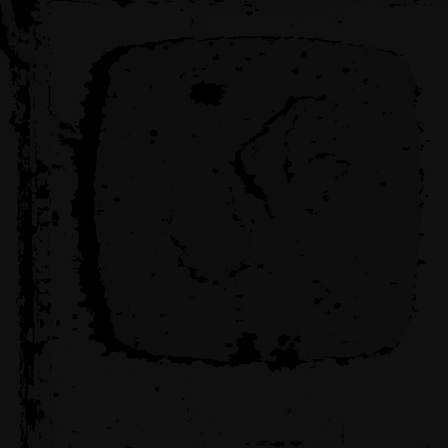

In [30]:
img_pil

In [31]:
print("\n--- Transformed Tensor ---")
print(f"Type: {type(img)}")
print(f"Shape: {img.shape}") # Expected: [1, H, W]
print(f"Data type: {img.dtype}")
print(f"Min value: {img.min().item():.4f}")
print(f"Max value: {img.max().item():.4f}")
print(f"Mean value: {img.mean().item():.4f}")
print(f"Std value: {img.std().item():.4f}")


--- Transformed Tensor ---
Type: <class 'torch.Tensor'>
Shape: torch.Size([1, 1, 448, 448])
Data type: torch.float32
Min value: -10.2897
Max value: 3.2008
Mean value: -0.8644
Std value: 3.1657


In [32]:
tokenized_depth = toks['tok_depth'].tokenize(img)
print(f"We have tokenized the Image input which results in discrete tokens. The shape of the tokenized tensor is f{tokenized_depth.shape}")

We have tokenized the Image input which results in discrete tokens. The shape of the tokenized tensor is ftorch.Size([1, 28, 28])


In [33]:
tokenized_depth

tensor([[[4175, 3718, 1724, 5789, 8144, 5811, 6596, 6706, 7050, 1280, 1746,
          1718, 7158, 4347, 4117, 3717, 4011, 6932, 7892, 4137, 4276, 2640,
          2110, 6517, 2252, 4817, 2329, 6370],
         [1008, 7540, 7631, 2929, 5795, 5335, 5447, 4271, 4915, 5610, 1827,
          4671, 3265, 6656, 5908, 6426, 2085, 1551,  827, 7570, 7100, 2822,
          5118, 7332, 4279, 4671, 4092, 7066],
         [ 268,  415, 5109, 4874, 3751, 7038, 4614, 6643, 1578, 5969, 7701,
          7087, 4314, 5926, 7335, 2129, 4720,  345, 3556, 6457,  818, 5552,
          7910,  919,  696, 5278, 2445, 1876],
         [7042, 4011, 3500, 1476, 3084,   70, 3858,  170, 2883, 1080, 1395,
          5620, 7496, 3103, 2430, 1903, 3140, 5550, 5173, 7542, 3956, 5872,
          6582,  581, 3597, 6092, 5908, 2824],
         [8144, 2781,  280, 4805, 3742, 4337, 4904, 7739, 5618, 2040, 2858,
          3039, 3381, 7051,  668, 4988, 3252, 3285, 7087,  944, 7111, 6398,
          7086,  630,  534, 5004, 8127, 5220],
     

In [34]:
reconstructed_depth = toks['tok_depth'].decode_tokens(tokenized_depth, image_size=448, timesteps=19)

/work/com-304/new_environment/anaconda3/envs/fourm/lib/python3.9/site-packages/fourm/vq/scheduling/diffusion_pipeline.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [35]:
reconstructed_depth.shape

torch.Size([1, 1, 448, 448])

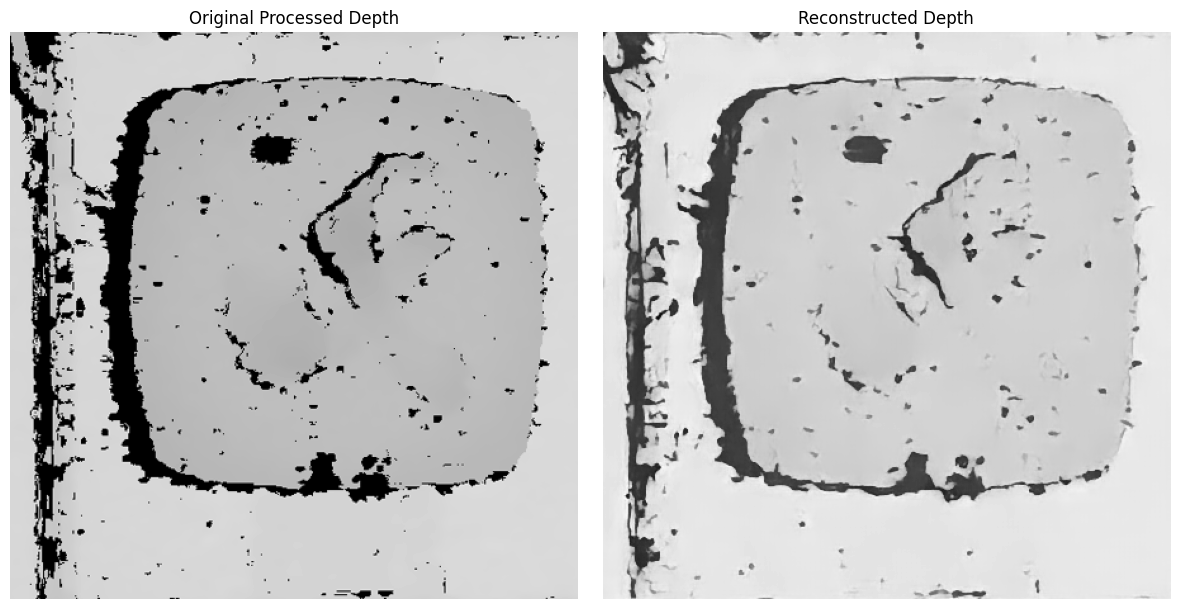

In [37]:
import matplotlib.pyplot as plt
import numpy as np # Ensure numpy is imported if not already

# Helper function to prepare a depth tensor for imshow (normalizes to 0-1)
def prepare_depth_for_display(tensor_bchw):
    """
    Prepares a batch of single-channel depth images for display.
    Selects the first image, first channel, moves to CPU, and normalizes to [0,1].
    Input tensor shape: [B, C, H, W] or [B, H, W] or [H,W]
    """
    if tensor_bchw.ndim == 4: # [B, C, H, W]
        # Assuming B=1, C=1 for a single depth image
        img_tensor = tensor_bchw[0, 0, :, :] 
    elif tensor_bchw.ndim == 3: # Could be [C, H, W] or [B, H, W]
        # If it's [1, H, W] (Batch-like dimension first)
        if tensor_bchw.shape[0] == 1:
            img_tensor = tensor_bchw[0, :, :]
        else: # Assume [C, H, W] where C > 1 is not expected for single depth
             raise ValueError(f"Unsupported 3D tensor shape for depth: {tensor_bchw.shape}. Expected [1, H, W].")
    elif tensor_bchw.ndim == 2: # [H, W]
        img_tensor = tensor_bchw
    else:
        raise ValueError(f"Unsupported tensor shape: {tensor_bchw.shape}")

    img_cpu = img_tensor.cpu().detach().numpy() # Detach from graph before numpy conversion

    # Normalize to [0, 1] for visualization
    min_val = np.min(img_cpu)
    max_val = np.max(img_cpu)
    if max_val - min_val > 1e-6: # Avoid division by zero for constant images
        normalized_img = (img_cpu - min_val) / (max_val - min_val)
    else:
        normalized_img = np.zeros_like(img_cpu) # Or handle as appropriate (e.g., img_cpu itself)
    return normalized_img

# Assuming 'img' and 'reconstructed_depth' are available from your previous code:
# img shape is likely [1, 1, 448, 448]
# reconstructed_depth shape is also likely [1, 1, 448, 448]

# Prepare images for display
original_depth_display = prepare_depth_for_display(img)
reconstructed_depth_display = prepare_depth_for_display(reconstructed_depth)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Increased figsize for better view

# Display the original processed depth image
axes[0].imshow(original_depth_display, cmap='gray') # 'viridis', 'plasma', 'gray' are good colormaps
axes[0].set_title("Original Processed Depth")
axes[0].axis("off")

# Display the reconstructed depth image
axes[1].imshow(reconstructed_depth_display, cmap='gray')
axes[1].set_title("Reconstructed Depth")
axes[1].axis("off")

plt.tight_layout()
plt.show()